# Market Microstructure Analysis - Basic Order Book

This notebook demonstrates:
- Building a limit order book from scratch
- Analyzing spread dynamics
- Computing depth and liquidity metrics
- Visualizing order book state

In [1]:
# Setup
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from decimal import Decimal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from src.engine.order_book import LimitOrderBook
from src.engine.order import Order, OrderSide, OrderType, TimeInForce
from src.replay.synthetic_generator import PoissonOrderGenerator
from src.analytics.metrics import MetricsCalculator

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful")

✅ Imports successful


## 1. Create Order Book and Generate Synthetic Data

In [2]:
# Create order book
book = LimitOrderBook("DEMO")

# Generate synthetic order flow
generator = PoissonOrderGenerator(
    symbol="DEMO",
    base_price=Decimal("100.0"),
    volatility=0.01,
    arrival_rate=50.0  # 50 orders/sec
)

# Collect snapshots over time
snapshots = []
trades_list = []

for i, event in enumerate(generator.generate_order_stream(duration_seconds=60.0)):
    if event["type"] == "new":
        order = event["order"]
        trades = book.add_order(order)
        trades_list.extend(trades)
        
        # Take snapshot every 10 orders
        if i % 10 == 0:
            snapshot = book.get_snapshot(levels=10)
            snapshots.append(snapshot)
    
    elif event["type"] == "cancel":
        book.cancel_order(event["order_id"])

print(f"Generated {len(snapshots)} snapshots")
print(f"Total trades: {len(trades_list)}")
print(f"Final mid price: ${book.mid_price}")

Generated 230 snapshots
Total trades: 2197
Final mid price: $87.24171191693287736196660455


## 2. Visualize Spread Dynamics

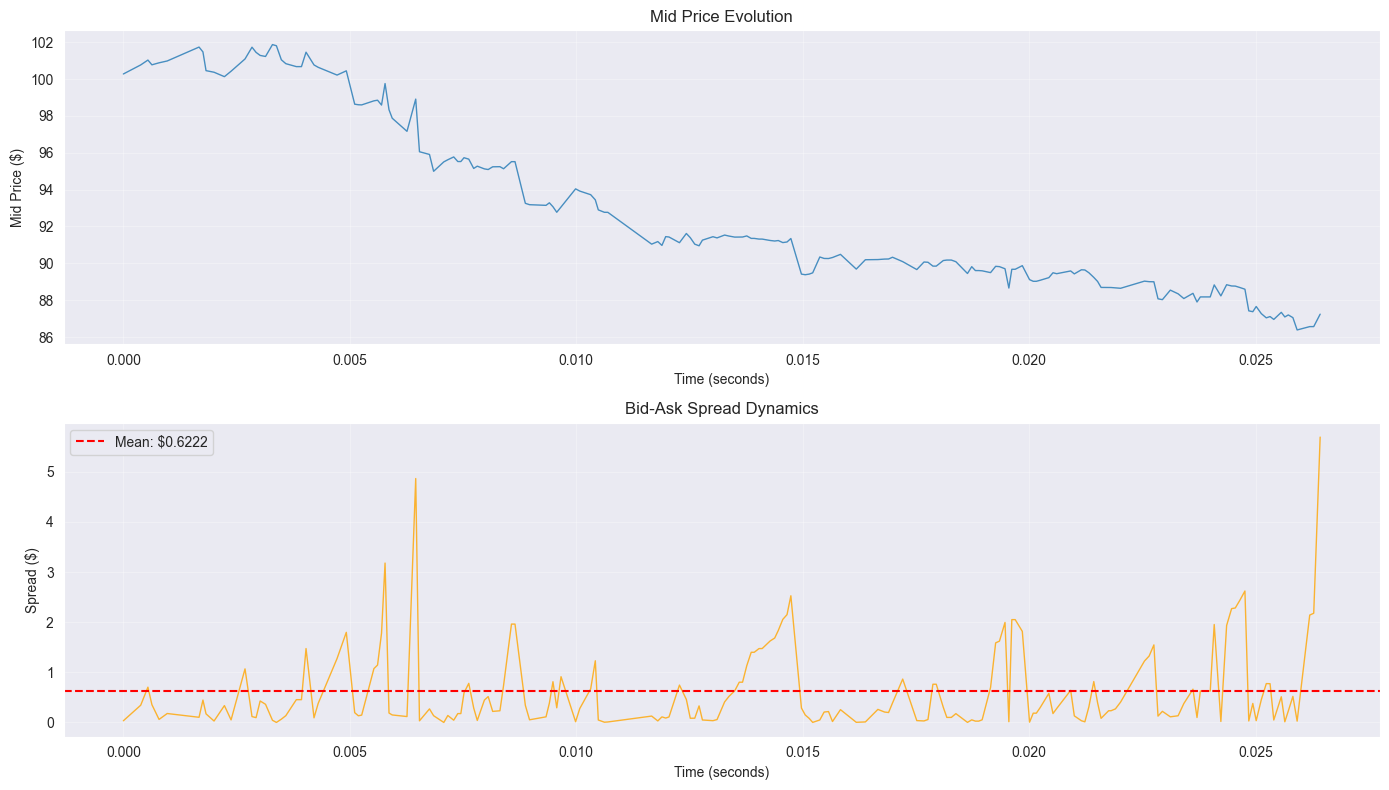

Mean spread: $0.6222
Spread volatility: $0.8319


In [3]:
# Extract time series
timestamps = [s.timestamp / 1e9 for s in snapshots if s.spread is not None]
spreads = [float(s.spread) for s in snapshots if s.spread is not None]
mids = [float(s.mid_price) for s in snapshots if s.mid_price is not None]

# Normalize timestamps to start at 0
timestamps = np.array(timestamps) - timestamps[0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Mid price evolution
ax1.plot(timestamps, mids, linewidth=1, alpha=0.8)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Mid Price ($)')
ax1.set_title('Mid Price Evolution')
ax1.grid(True, alpha=0.3)

# Spread evolution
ax2.plot(timestamps, spreads, linewidth=1, alpha=0.8, color='orange')
ax2.axhline(np.mean(spreads), color='red', linestyle='--', label=f'Mean: ${np.mean(spreads):.4f}')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Spread ($)')
ax2.set_title('Bid-Ask Spread Dynamics')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean spread: ${np.mean(spreads):.4f}")
print(f"Spread volatility: ${np.std(spreads):.4f}")

## 3. Order Book Depth Visualization

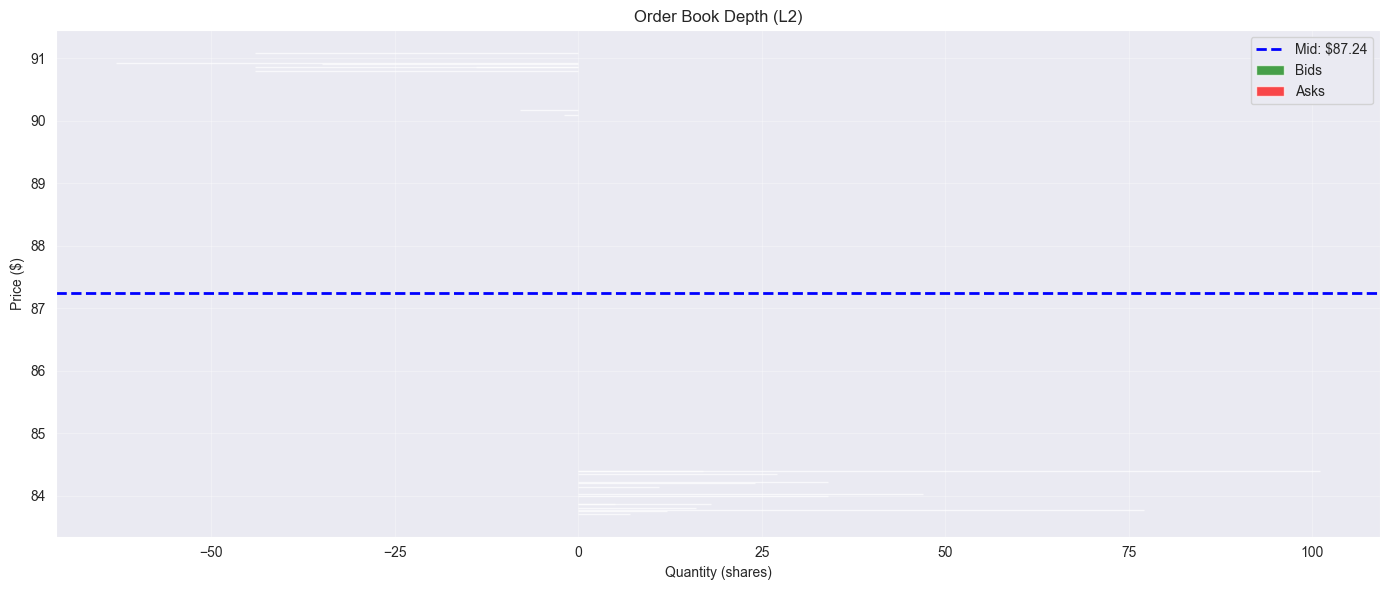

Total bid depth (top 10): 318 shares
Total ask depth (top 10): 254 shares


In [4]:
# Take a snapshot
snapshot = book.get_snapshot(levels=20)

# Extract bid/ask data
bid_prices = [float(p) for p, q in snapshot.bids]
bid_sizes = [float(q) for p, q in snapshot.bids]
ask_prices = [float(p) for p, q in snapshot.asks]
ask_sizes = [float(q) for p, q in snapshot.asks]

# Create depth visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Bids (green)
ax.barh(bid_prices, bid_sizes, height=0.001, alpha=0.7, color='green', label='Bids')

# Asks (red)
ax.barh(ask_prices, [-s for s in ask_sizes], height=0.001, alpha=0.7, color='red', label='Asks')

# Mark mid price
if snapshot.mid_price:
    ax.axhline(float(snapshot.mid_price), color='blue', linestyle='--', linewidth=2, label=f'Mid: ${snapshot.mid_price:.2f}')

ax.set_xlabel('Quantity (shares)')
ax.set_ylabel('Price ($)')
ax.set_title('Order Book Depth (L2)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total bid depth (top 10): {sum(bid_sizes[:10]):,.0f} shares")
print(f"Total ask depth (top 10): {sum(ask_sizes[:10]):,.0f} shares")

## 4. Compute Microstructure Metrics

In [5]:
# Compute metrics
metrics = MetricsCalculator.compute_from_snapshots(snapshots, trades_list)

# Display as DataFrame
metrics_data = {
    'Metric': [
        'Mean Spread ($)',
        'Median Spread ($)',
        'Spread Volatility ($)',
        'Mean Bid Depth (shares)',
        'Mean Ask Depth (shares)',
        'Depth Imbalance',
        'Order Flow Imbalance',
        'Number of Trades',
        'Total Volume (shares)',
        'VWAP ($)',
        'Realized Volatility',
    ],
    'Value': [
        f"{metrics.mean_spread:.4f}",
        f"{metrics.median_spread:.4f}",
        f"{metrics.spread_volatility:.4f}",
        f"{metrics.mean_depth_bid:,.0f}",
        f"{metrics.mean_depth_ask:,.0f}",
        f"{metrics.depth_imbalance:+.3f}",
        f"{metrics.order_flow_imbalance:+.3f}",
        f"{metrics.num_trades:,}",
        f"{metrics.total_volume:,.0f}",
        f"{metrics.vwap:.4f}" if metrics.vwap else "N/A",
        f"{metrics.realized_volatility:.2%}",
    ]
}

df_metrics = pd.DataFrame(metrics_data)
print("\n📊 Market Microstructure Metrics:")
print("=" * 50)
print(df_metrics.to_string(index=False))


📊 Market Microstructure Metrics:
                 Metric   Value
        Mean Spread ($)  0.6222
      Median Spread ($)  0.2829
  Spread Volatility ($)  0.8319
Mean Bid Depth (shares)     159
Mean Ask Depth (shares)     189
        Depth Imbalance  -0.086
   Order Flow Imbalance  -0.072
       Number of Trades   2,197
  Total Volume (shares)  36,522
               VWAP ($) 92.8098
    Realized Volatility   7.61%


## 5. Trade Analysis

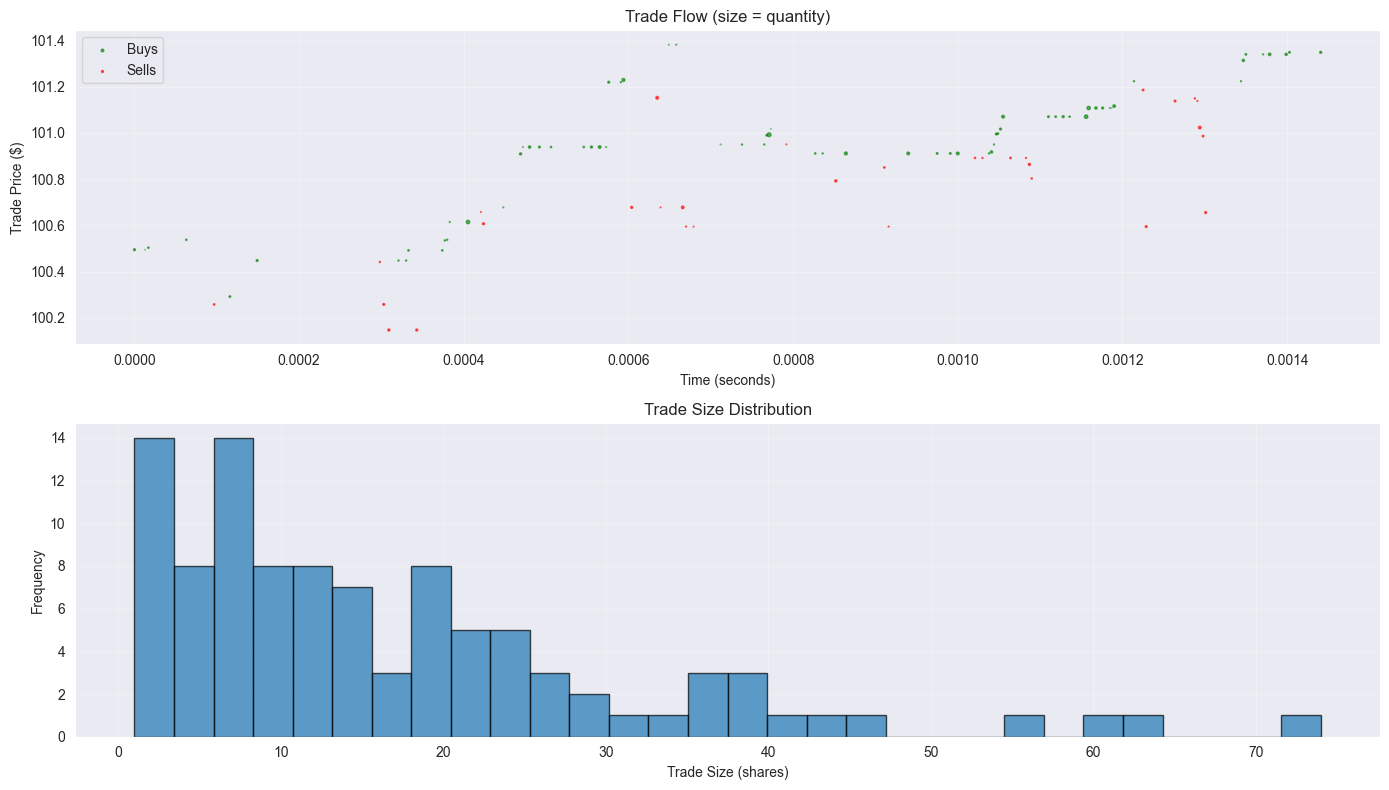


Buy volume:  1,223 shares
Sell volume: 450 shares


In [6]:
if trades_list:
    # Create trades DataFrame
    trades_df = pd.DataFrame([
        {
            'timestamp': t.timestamp / 1e9,
            'price': float(t.price),
            'quantity': float(t.quantity),
            'side': t.aggressor_side.value
        }
        for t in trades_list[:100]  # First 100 trades
    ])
    
    # Normalize timestamps
    trades_df['timestamp'] = trades_df['timestamp'] - trades_df['timestamp'].min()
    
    # Plot trades over time
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # Price evolution with buys/sells
    buy_trades = trades_df[trades_df['side'] == 'BUY']
    sell_trades = trades_df[trades_df['side'] == 'SELL']
    
    ax1.scatter(buy_trades['timestamp'], buy_trades['price'], 
                c='green', s=buy_trades['quantity']/10, alpha=0.6, label='Buys')
    ax1.scatter(sell_trades['timestamp'], sell_trades['price'], 
                c='red', s=sell_trades['quantity']/10, alpha=0.6, label='Sells')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Trade Price ($)')
    ax1.set_title('Trade Flow (size = quantity)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Volume distribution
    ax2.hist(trades_df['quantity'], bins=30, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Trade Size (shares)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Trade Size Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBuy volume:  {buy_trades['quantity'].sum():,.0f} shares")
    print(f"Sell volume: {sell_trades['quantity'].sum():,.0f} shares")
else:
    print("No trades generated during simulation")

## Summary

This notebook demonstrated:
- ✅ Building and populating a limit order book
- ✅ Generating realistic synthetic order flow
- ✅ Visualizing spread and mid-price dynamics
- ✅ Analyzing order book depth
- ✅ Computing microstructure metrics
- ✅ Analyzing trade flow patterns

### Next Steps
- Explore strategy backtesting in `02_strategy_backtesting.ipynb`
- Learn about market impact models
- Analyze real market data (if available)